In [1]:
import cv2
import mediapipe as mp
import time # Calculate fps values

In [4]:
def get_df_lstm(df_origin):
# Group by TYPE, FILE, FRAME and merge XYZ of each group into an array
    df_lstm = df_origin.groupby(['TYPE', 'FILE', 'FRAME'])['X', 'Y', 'Z'].apply(lambda x: x.values.flatten().tolist()).reset_index()
    df_lstm.drop(columns=['TYPE'], inplace=True)
    df_lstm.rename(columns={0: 'POSE'}, inplace=True)
    return df_lstm

In [5]:
import pandas as pd

# Read the action data CSV file of the hyperactive phase
df_manic_phase = pd.read_csv('data/manic_phase_xyz_coordinates.csv')
df_lstm_manic_phase = get_df_lstm(df_manic_phase)
df_lstm_manic_phase['LABEL']=1
df_lstm_manic_phase['FILE'] = df_lstm_manic_phase['FILE'].apply(lambda x: 'manic_' + str(x) )
print(df_lstm_manic_phase.shape[0])
print(df_lstm_manic_phase)

#Read CSV file of action data for depression period
df_Depression_phase = pd.read_csv('data/Depression_phase_all_xyz_coordinates.csv')
df_lstm_Depression_phase = get_df_lstm(df_Depression_phase)
df_lstm_Depression_phase['LABEL']=0
df_lstm_Depression_phase['FILE'] = df_lstm_Depression_phase['FILE'].apply(lambda x: 'depression_' + str(x) )
print(df_lstm_Depression_phase)

C:\Users\ginny\AppData\Local\Temp\ipykernel_24920\2481263422.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_lstm = df_origin.groupby(['TYPE', 'FILE', 'FRAME'])['X', 'Y', 'Z'].apply(lambda x: x.values.flatten().tolist()).reset_index()


45135
                          FILE  FRAME  \
0      manic_angry/angry_1.mp4      1   
1      manic_angry/angry_1.mp4      2   
2      manic_angry/angry_1.mp4      3   
3      manic_angry/angry_1.mp4      4   
4      manic_angry/angry_1.mp4      5   
...                        ...    ...   
45130  manic_happy/high_99.mp4     86   
45131  manic_happy/high_99.mp4     87   
45132  manic_happy/high_99.mp4     88   
45133  manic_happy/high_99.mp4     89   
45134  manic_happy/high_99.mp4     90   

                                                    POSE  LABEL  
0      [0.6712705492973328, 0.2354803681373596, -0.44...      1  
1      [0.670484721660614, 0.2354438751935959, -0.450...      1  
2      [0.6686055660247803, 0.2352340519428253, -0.45...      1  
3      [0.6668257117271423, 0.2351486831903457, -0.44...      1  
4      [0.6650943160057068, 0.2347503304481506, -0.45...      1  
...                                                  ...    ...  
45130  [0.5850008130073547, 0.158889397

C:\Users\ginny\AppData\Local\Temp\ipykernel_24920\2481263422.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_lstm = df_origin.groupby(['TYPE', 'FILE', 'FRAME'])['X', 'Y', 'Z'].apply(lambda x: x.values.flatten().tolist()).reset_index()


                                   FILE  FRAME  \
0      depression_anxiety/anxiety_1.mp4      1   
1      depression_anxiety/anxiety_1.mp4      2   
2      depression_anxiety/anxiety_1.mp4      3   
3      depression_anxiety/anxiety_1.mp4      4   
4      depression_anxiety/anxiety_1.mp4      5   
...                                 ...    ...   
62925         depression_sad/cry_99.mp4     86   
62926         depression_sad/cry_99.mp4     87   
62927         depression_sad/cry_99.mp4     88   
62928         depression_sad/cry_99.mp4     89   
62929         depression_sad/cry_99.mp4     90   

                                                    POSE  LABEL  
0      [0.5519856810569763, 0.3506132960319519, -0.35...      0  
1      [0.5530905723571777, 0.3474056422710418, -0.37...      0  
2      [0.5539628267288208, 0.3418100476264953, -0.38...      0  
3      [0.5659641027450562, 0.3321160078048706, -0.41...      0  
4      [0.5708790421485901, 0.3186957240104675, -0.41...      0  
...

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [7]:
data = pd.concat([df_lstm_manic_phase, df_lstm_Depression_phase]).reset_index()

data = data.drop(data[(data['FILE'] == 'manic_angry/angry_1.mp4') | (data['FILE'] == 'depression_anxiety/anxiety_1.mp4')].index).reset_index()

# Data pre-processing
max_frames = data['FRAME'].max()
num_features = len(data['POSE'][0])  # of features in the attitude data
print(max_frames, num_features)

# Grouping and counting by FILE columns
count = data.groupby('FILE').size().reset_index(name='COUNT')
print(count)

X = []
y = []

for file in data['FILE'].unique():
    file_data = data[data['FILE'] == file]
#     print(file,file_data['FRAME'].max())
    poses = np.array(file_data['POSE'].tolist())
#     print(poses)
    label = file_data['LABEL'].iloc[0]
    
    # Fill pose data to max_frames length
    padded_poses = np.zeros((max_frames, num_features))
    padded_poses[:poses.shape[0], :poses.shape[1]] = poses
    
    X.append(padded_poses)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(len(X))
# print(X[0][111])
# print(y[0],y[21])



90 75
                                    FILE  COUNT
0      depression_anxiety/anxiety_10.mp4     90
1     depression_anxiety/anxiety_100.mp4     90
2     depression_anxiety/anxiety_101.mp4     90
3     depression_anxiety/anxiety_102.mp4     90
4     depression_anxiety/anxiety_103.mp4     90
...                                  ...    ...
1208             manic_happy/high_95.mp4     90
1209             manic_happy/high_96.mp4     90
1210             manic_happy/high_97.mp4     90
1211             manic_happy/high_98.mp4     90
1212             manic_happy/high_99.mp4     90

[1213 rows x 2 columns]
1213


In [8]:
# Delineate training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [56]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(max_frames, num_features), return_sequences=True))
model.add(Dropout(0.5))

#Add additional LSTM layers
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

# Add a third LSTM layer (additional LSTM layer)
model.add(LSTM(32, return_sequences=True))  #添加一层额外的 LSTM 层
model.add(Dropout(0.5))

# Add a fourth LSTM layer (additional LSTM layer)
#model.add(LSTM(16)) 
#model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training models
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Save the model
model.save('lstm_emotion_detection_test.h5')

Epoch 1/100
23/23 [==============================] - 11s 280ms/step - loss: 0.9191 - accuracy: 0.5022 - val_loss: 0.6949 - val_accuracy: 0.5688
Epoch 2/100
23/23 [==============================] - 5s 195ms/step - loss: 0.7405 - accuracy: 0.5231 - val_loss: 0.6959 - val_accuracy: 0.5331
Epoch 3/100
23/23 [==============================] - 5s 199ms/step - loss: 0.7254 - accuracy: 0.5340 - val_loss: 0.7036 - val_accuracy: 0.4657
Epoch 4/100
23/23 [==============================] - 5s 201ms/step - loss: 1.2744 - accuracy: 0.4604 - val_loss: 0.9105 - val_accuracy: 0.4259
Epoch 5/100
23/23 [==============================] - 5s 220ms/step - loss: 1.0789 - accuracy: 0.4503 - val_loss: 0.7719 - val_accuracy: 0.4259
Epoch 6/100
23/23 [==============================] - 5s 200ms/step - loss: 0.9396 - accuracy: 0.4592 - val_loss: 0.7376 - val_accuracy: 0.4259
Epoch 7/100
23/23 [==============================] - 5s 229ms/step - loss: 0.8423 - accuracy: 0.4696 - val_loss: 0.7218 - val_accuracy: 0.426

Epoch 58/100
23/23 [==============================] - 5s 203ms/step - loss: 0.6842 - accuracy: 0.5785 - val_loss: 0.6826 - val_accuracy: 0.5741
Epoch 59/100
23/23 [==============================] - 5s 227ms/step - loss: 0.6842 - accuracy: 0.5766 - val_loss: 0.6831 - val_accuracy: 0.5741
Epoch 60/100
23/23 [==============================] - 5s 218ms/step - loss: 0.6835 - accuracy: 0.5799 - val_loss: 0.6823 - val_accuracy: 0.5741
Epoch 61/100
23/23 [==============================] - 4s 193ms/step - loss: 0.6837 - accuracy: 0.5761 - val_loss: 0.6826 - val_accuracy: 0.5741
Epoch 62/100
23/23 [==============================] - 5s 217ms/step - loss: 0.6835 - accuracy: 0.5775 - val_loss: 0.6832 - val_accuracy: 0.5741
Epoch 63/100
23/23 [==============================] - 5s 206ms/step - loss: 0.6836 - accuracy: 0.5789 - val_loss: 0.6832 - val_accuracy: 0.5741
Epoch 64/100
23/23 [==============================] - 5s 228ms/step - loss: 0.6831 - accuracy: 0.5791 - val_loss: 0.6834 - val_accuracy:

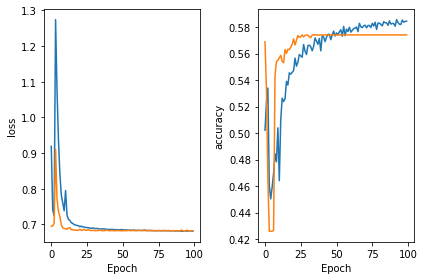

In [60]:
#Visualisation
#Import libraries needed for visualisation
import matplotlib.pyplot as plt

# Plot our loss
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# Plot our accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.tight_layout()
plt.show()

In [58]:
# Use the trained model to classify the characters in the video as belonging to the hyperactive or depressive phase
def predict_phase(model, pose_data):
    # Pre-processing of input data
    padded_poses = np.zeros((1, max_frames, num_features))
    padded_poses[0, :pose_data.shape[0], :pose_data.shape[1]] = pose_data
    
    # Predictions
    prediction = model.predict(padded_poses)
    print(prediction, padded_poses)
    return 1 if prediction >= 0.5 else 0

In [59]:
# Remove the unique value of the FILE column in the df_lstm_manic_phase DataFrame (de-emphasis) for each file in the manic_phase
unique_files = df_lstm_manic_phase['FILE'].unique()
# Iterate through the list of filenames and export the pose data for each file

correct_num = 0 #A counter that records the number of videos correctly predicted by the model to be in the "manic" phase.
# Iterate through the list of filenames and export the pose data for each file.
for file_name in unique_files:
    poses = df_lstm_manic_phase.loc[df_lstm_manic_phase['FILE'] == file_name, 'POSE'].apply(lambda x: x).tolist()
    new_video_pose_data = np.array(poses)  # Input the pose data for the new video here
    is_manic = predict_phase(model, new_video_pose_data)
    if is_manic :
        correct_num+=1
    print("is in manic phase" if is_manic else "is in depression phase")
print(correct_num,len(unique_files),correct_num / len(unique_files))

1/1 [==============================] - 1s 980ms/step
[[[0.41887757]
  [0.4393199 ]
  [0.44844967]
  [0.45003837]
  [0.4474658 ]
  [0.44312623]
  [0.43845487]
  [0.4341478 ]
  [0.4305688 ]
  [0.42774597]
  [0.4256069 ]
  [0.42404577]
  [0.42293507]
  [0.42217335]
  [0.4216664 ]
  [0.4213403 ]
  [0.4211413 ]
  [0.42103532]
  [0.4209443 ]
  [0.420909  ]
  [0.42087767]
  [0.42082208]
  [0.4207717 ]
  [0.4207218 ]
  [0.42065898]
  [0.42058533]
  [0.4205109 ]
  [0.42043996]
  [0.42037103]
  [0.42030427]
  [0.42023826]
  [0.42018878]
  [0.42015097]
  [0.4201263 ]
  [0.42012   ]
  [0.42012006]
  [0.42010763]
  [0.42009172]
  [0.42007014]
  [0.42004254]
  [0.42000237]
  [0.41995665]
  [0.4198967 ]
  [0.4198396 ]
  [0.41977108]
  [0.41971627]
  [0.41962355]
  [0.41963512]
  [0.41963577]
  [0.41965976]
  [0.4196923 ]
  [0.4197131 ]
  [0.41974896]
  [0.4198143 ]
  [0.41989216]
  [0.41995993]
  [0.4200072 ]
  [0.4200452 ]
  [0.42009532]
  [0.42012957]
  [0.4201768 ]
  [0.4202342 ]
  [0.42027467]
  

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Remove the unique value of the FILE column in the df_lstm_manic_phase DataFrame (de-emphasis) for each file in the manic_phase
unique_files = df_lstm_Depression_phase['FILE'].unique()
# Iterate through the list of filenames and export the pose data for each file

correct_num = 0 #A counter that records the number of videos correctly predicted by the model to be in the "manic" phase.
# Iterate through the list of filenames and export the pose data for each file.
for file_name in unique_files:
    poses = df_lstm_Depression_phase.loc[df_lstm_Depression_phase['FILE'] == file_name, 'POSE'].apply(lambda x: x).tolist()
    new_video_pose_data = np.array(poses)  # Input the pose data for the new video here
    is_manic = predict_phase(model, new_video_pose_data)
    if not is_manic :
        correct_num+=1
    print("is in manic phase" if is_manic else "is in depression phase")
print(correct_num,len(unique_files),correct_num / len(unique_files))